In [1]:
import pandas as pd
from sklearn.cluster import KMeans, AgglomerativeClustering
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

In [43]:
df = pd.read_csv('adjacency_matrix.csv', index_col='Id')
df_cluster = df.copy()

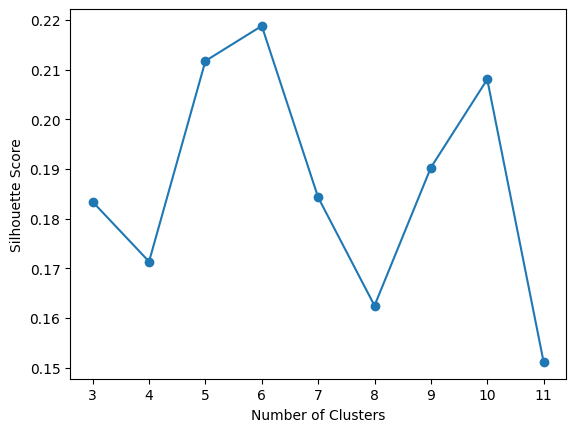

In [45]:
# Apply K-means clustering
k_values = [3,4,5,6,7,8,9,10,11]
silhouette_scores = []
for k in k_values:
    model = KMeans(n_clusters=k)
    df_cluster['kmeans'] = model.fit_predict(df)
    silhouette_avg = silhouette_score(df, df_cluster['kmeans'])
    silhouette_scores.append(silhouette_avg)

plt.plot(k_values, silhouette_scores, marker = 'o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()


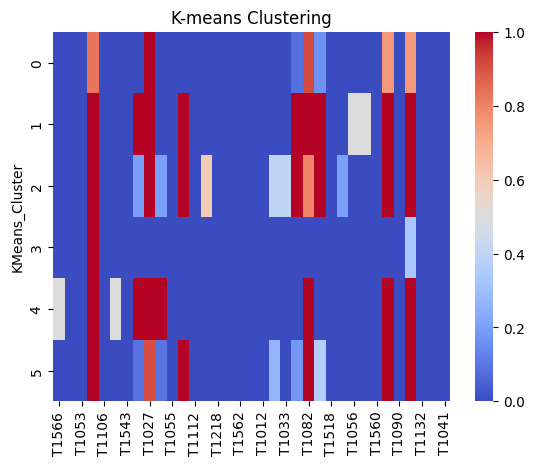

In [46]:
kmeans = KMeans(n_clusters=6, random_state=42)  # You can choose the number of clusters
kmeans.fit(df)
df['KMeans_Cluster'] = kmeans.labels_

silhouette_kmeans = silhouette_score(df, kmeans.labels_)
# Visualize the clusters using a heatmap
sns.heatmap(df.groupby('KMeans_Cluster').mean(), cmap='coolwarm')
plt.title('K-means Clustering')
plt.show()

df = df.drop(columns='KMeans_Cluster')

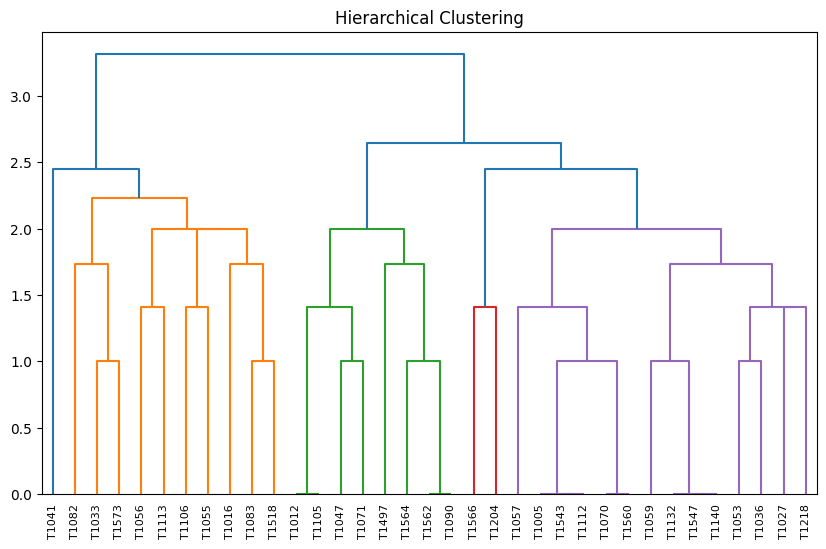

In [47]:
# Apply hierarchical clustering
linkage = hierarchy.linkage(df, method='complete', metric='euclidean')

# Visualize the clusters using a dendrogram
plt.figure(figsize=(10, 6))
dendrogram = hierarchy.dendrogram(linkage, labels=df.index, leaf_rotation=90)
plt.title('Hierarchical Clustering')
plt.show()

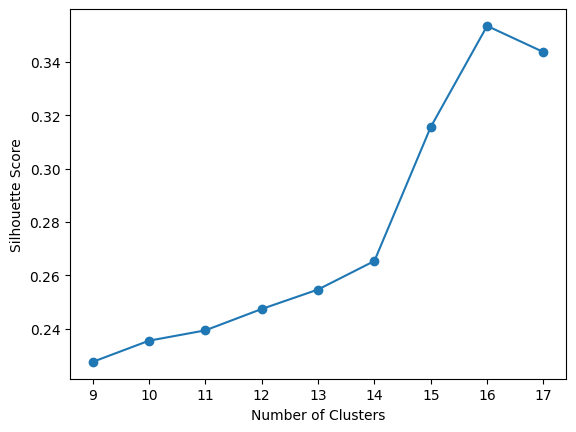

In [51]:
k_values = [9,10,11,12,13,14,15,16,17]
silhouette_scores = []
for k in k_values:
    model = AgglomerativeClustering(n_clusters=k)
    df_cluster['agg'] = model.fit_predict(df)
    silhouette_avg = silhouette_score(df, df_cluster['agg'])
    silhouette_scores.append(silhouette_avg)

plt.plot(k_values, silhouette_scores, marker = 'o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [52]:
# Perform Agglomerative Clustering
agg = AgglomerativeClustering(n_clusters=16)
agg_labels = agg.fit_predict(df)
silhouette_agg = silhouette_score(df, agg_labels)

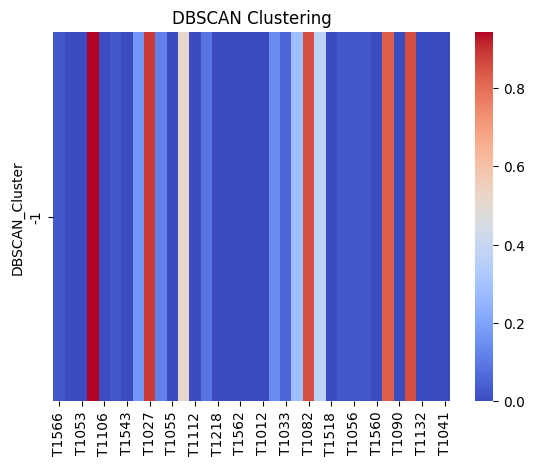

In [56]:
# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(df)
df['DBSCAN_Cluster'] = dbscan_labels
#silhouette_dbscan = silhouette_score(df, dbscan_labels[dbscan_labels != -1])
# Visualize the clusters using a heatmap
sns.heatmap(df.groupby('DBSCAN_Cluster').mean(), cmap='coolwarm')
plt.title('DBSCAN Clustering')
plt.show()
df = df.drop(columns='DBSCAN_Cluster')

In [57]:
# Compare silhouette scores
print("Silhouette Score - KMeans:", silhouette_kmeans)
print("Silhouette Score - Agglomerative Clustering:", silhouette_agg)
#print("Silhouette Score - DBSCAN:", silhouette_dbscan)

Silhouette Score - KMeans: 0.44629830348566907
Silhouette Score - Agglomerative Clustering: 0.3535637075567186


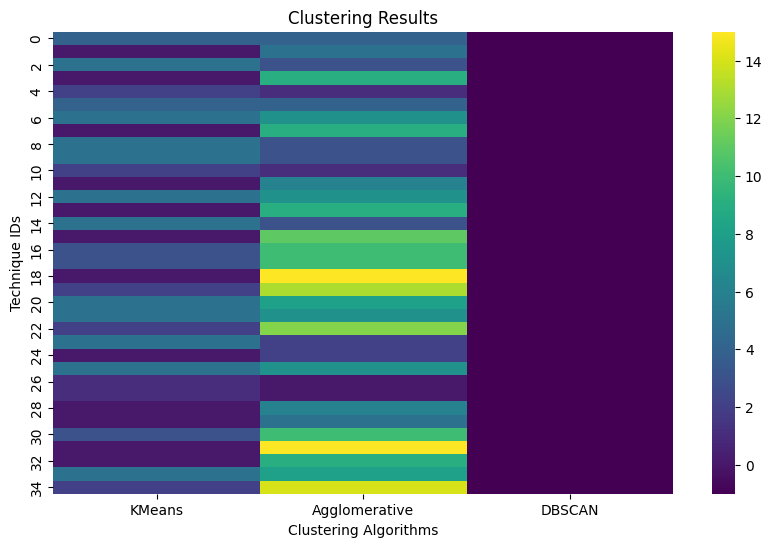

In [58]:

# Create a DataFrame with the clustering labels
clustered_df = pd.DataFrame({'KMeans': kmeans.labels_,
                             'Agglomerative': agg_labels,
                             'DBSCAN': dbscan_labels})

# Plot the clustered DataFrame as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(clustered_df, cmap='viridis')
plt.title('Clustering Results')
plt.xlabel('Clustering Algorithms')
plt.ylabel('Technique IDs')
plt.show()